# Apprentissage par renforcement

In [13]:
import numpy as np
import pandas as pd
import time

# N_ETATS : Le nombre d'états possibles avant d'atteindre la cible.
# ACTIONS : Les actions possibles de l'agent ('gauche' ou 'droite').
# EPSILON : La probabilité de choisir une action au hasard plutôt que la meilleure action connue, pour explorer l'environnement.
# ALPHA : Le taux d'apprentissage, qui détermine à quel point les nouvelles informations remplacent les anciennes.
# GAMMA : Le facteur de remise, qui détermine l'importance des récompenses futures.
# MAX_CYCLES : Le nombre maximum de cycles d'entraînement.
# TPS_MOUV : Le temps entre les mouvements, pour la simulation.

# A---CIBLE
# Le nombre de positions possibles avant d'atteindre la cible avec le moins de déplacements possible
N_ETATS = 5
# Les actions réalisables par l'agent
ACTIONS = ['gauche', 'droite']
# La valeur qui permet d'indiquer si une action de l'agent est aléatoire ou encore basée sur la qualité
EPSILON = 0.9
# Le taux d'apprentissage qui varie de 0 (l'agent n'a rien appris) à 1 (l'agent ne tient compte que de la dernière
#information apprise)
ALPHA = 0.1
# Le coefficient de réduction
GAMMA = 0.7
# Le nombre de cycles
MAX_CYCLES = 5
# La vitesse des mouvements
TPS_MOUV = 0.1

# Construction d'une Q table
def Construire_q_table(n_etats, actions):
    """
    Construit une Q-table initialisée à zéro pour un nombre donné d'états et d'actions.

    :param n_etats: Nombre d'états dans l'environnement.
    :param actions: Liste des actions possibles.
    :return: DataFrame pandas représentant la Q-table.
    """
    table = pd.DataFrame(np.zeros((n_etats, len(actions))),columns=actions)
    print(f"\nQ table :\n{table} \n")
    return table

# Choix de l'action en fonction de l'état et de la Q table
def choix_action(etat, q_table):
    """
    Sélectionne une action pour un état donné en utilisant la politique epsilon-greedy.

    :param etat: L'état actuel de l'agent.
    :param q_table: La Q-table utilisée pour choisir l'action.
    :return: L'action choisie.
    """
    etat_actions = q_table.iloc[etat, :]
    print(f"\netat_actions :\n{etat_actions} \n")
    if (np.random.uniform() > EPSILON) or ((etat_actions ==0).all()):
        nom_action = np.random.choice(ACTIONS)
    else:
        nom_action = etat_actions.idxmax()
    print(f"\nnom_action :\n{nom_action} \n")
    return nom_action

# Fonction qui indique le nouvel état et la récompense en
#fonction de l'état et de l'action
def nouv_etat_r(E, A):
    """
    Détermine le nouvel état et la récompense basés sur l'état actuel et l'action prise.

    :param E: L'état actuel.
    :param A: L'action effectuée.
    :return: Le nouvel état et la récompense associée.
    """
    if A == 'droite':
        if E == N_ETATS - 2:
            E_ = 'cible'
            R = 1
        else:
            E_ = E + 1
            R = 0
    else:
        R = 0
        if E == 0:
            E_ = E
        else:
            E_ = E - 1
    print(f"\nE_ :\n{E_} ,R  {R} \n")
    return E_, R

# Fonction qui met à jour l'environnement
def maj_env(S, cycle, c_etape):
    """
    Met à jour l'environnement de simulation en affichant l'état actuel et le cycle.

    :param S: L'état actuel ou 'cible' si atteint.
    :param cycle: Le numéro du cycle actuel.
    :param c_etape: Le compteur d'étapes dans le cycle actuel.
    """
    env_list = ['-']*(N_ETATS-1) + ['Cible']
    # print(f"\nenv_list :\n{env_list} \n")
    if S == 'cible':
        interaction = 'Cycle %s: nombre_pas = %s' % (cycle+1,c_etape)
        print('\r{}'.format(interaction), end='')
        time.sleep(1)
        print('\r', end='')
    else:
        env_list[S] = 'A'
        interaction = ''.join(env_list)
        print('\r{}'.format(interaction), end='')
        time.sleep(TPS_MOUV)

def apprentissage_renforcement():
    """
    Cette fonction implémente l'algorithme d'apprentissage par renforcement.
    Elle construit une table Q et effectue un certain nombre de cycles d'apprentissage.
    Chaque cycle consiste en une série d'étapes jusqu'à atteindre l'état 'cible'.
    À chaque étape, une action est choisie et l'état est mis à jour en fonction de cette action.
    La table Q est mise à jour à chaque étape en utilisant l'équation de Bellman.
    """

    # Construire la table Q initiale
    q_table = Construire_q_table(N_ETATS, ACTIONS)
    print(f"\nq_table :\n{q_table} \n")
    # Boucle sur le nombre maximal de cycles
    for cycle in range(MAX_CYCLES):
        c_etape = 0  # Initialiser le compteur d'étapes
        E = 0  # Initialiser l'état
        fin_cycle = False  # Indicateur de fin de cycle

        # Mettre à jour l'environnement
        maj_env(E, cycle, c_etape)

        # Boucle jusqu'à la fin du cycle
        while not fin_cycle:
            # Choisir une action en fonction de l'état et de la table Q
            A = choix_action(E, q_table)
            # Obtenir le nouvel état et la récompense en fonction de l'état actuel et de l'action choisie
            E_, R = nouv_etat_r(E, A)
            # Prédire la valeur Q pour l'état actuel et l'action choisie
            q_pred = q_table.loc[E, A]
            # Si le nouvel état n'est pas l'état 'cible'
            if E_ != 'cible':
                # Calculer la valeur cible Q en utilisant l'équation de Bellman
                q_cible = R + GAMMA * q_table.iloc[E_, :].max()
            else:
                # Si le nouvel état est l'état 'cible', la valeur cible Q est simplement la récompense
                q_cible = R
                # Indiquer la fin du cycle
                fin_cycle = True
            # Mettre à jour la valeur Q pour l'état actuel et l'action choisie
            q_table.loc[E, A] += ALPHA * (q_cible - q_pred)
            # Mettre à jour l'état
            E = E_
            # Mettre à jour l'environnement
            maj_env(E, cycle, c_etape+1)
            # Incrémenter le compteur d'étapes
            c_etape += 1

    # Retourner la table Q après l'apprentissage
    return q_table


In [14]:
# Lancement de l'algorithme
q_table = apprentissage_renforcement()
print('\r Q-table :\n', q_table)



Q table :
   gauche  droite
0     0.0     0.0
1     0.0     0.0
2     0.0     0.0
3     0.0     0.0
4     0.0     0.0 


q_table :
   gauche  droite
0     0.0     0.0
1     0.0     0.0
2     0.0     0.0
3     0.0     0.0
4     0.0     0.0 

A---Cible
etat_actions :
gauche    0.0
droite    0.0
Name: 0, dtype: float64 


nom_action :
gauche 


E_ :
0 ,R  0 

A---Cible
etat_actions :
gauche    0.0
droite    0.0
Name: 0, dtype: float64 


nom_action :
droite 


E_ :
1 ,R  0 

-A--Cible
etat_actions :
gauche    0.0
droite    0.0
Name: 1, dtype: float64 


nom_action :
droite 


E_ :
2 ,R  0 

--A-Cible
etat_actions :
gauche    0.0
droite    0.0
Name: 2, dtype: float64 


nom_action :
gauche 


E_ :
1 ,R  0 

-A--Cible
etat_actions :
gauche    0.0
droite    0.0
Name: 1, dtype: float64 


nom_action :
gauche 


E_ :
0 ,R  0 

A---Cible
etat_actions :
gauche    0.0
droite    0.0
Name: 0, dtype: float64 


nom_action :
droite 


E_ :
1 ,R  0 

-A--Cible
etat_actions :
gauche    0.0
droite    0

In [10]:
for _ in range(10):
    q_table = apprentissage_renforcement()
    print('\r Q-table :\n', q_table)


 Q-table :ombre_pas = 43
    gauche    droite
0     0.0  0.000158
1     0.0  0.004194
2     0.0  0.057022
3     0.0  0.409510
4     0.0  0.000000
 Q-table :ombre_pas = 40
      gauche    droite
0  0.000000  0.000213
1  0.000000  0.004552
2  0.000034  0.057022
3  0.000000  0.409510
4  0.000000  0.000000
 Q-table :ombre_pas = 41
      gauche    droite
0  0.000000  0.000266
1  0.000005  0.005623
2  0.000034  0.070800
3  0.002563  0.409510
4  0.000000  0.000000
 Q-table :ombre_pas = 43
    gauche    droite
0     0.0  0.000158
1     0.0  0.004194
2     0.0  0.057022
3     0.0  0.409510
4     0.0  0.000000
 Q-table :ombre_pas = 42
    gauche    droite
0     0.0  0.000158
1     0.0  0.004194
2     0.0  0.057022
3     0.0  0.409510
4     0.0  0.000000
 Q-table :ombre_pas = 40
    gauche    droite
0     0.0  0.000158
1     0.0  0.004194
2     0.0  0.057022
3     0.0  0.409510
4     0.0  0.000000
 Q-table :ombre_pas = 46
    gauche    droite
0     0.0  0.000158
1     0.0  0.004194
2     0.0  0.0

# Implementation Keras
## TensorFlow lite
https://www.tensorflow.org/lite/examples/reinforcement_learning/overview?hl=fr


## Vintel38 DeepRL
L'algorithme Actor Critic est une famille d'algorithme de Reinforcement Learning qui divise la tâche de sélection de l'action en deux parties à savoir :

une partie (Critic) qui évalue l'intérêt ou la valeur de l'action au regard de l'environnement et du système considéré
une partie (Actor) qui en utilisant les informations générées par le Critic choisit effectivement l'action pour l'état présent


https://github.com/vintel38/DeepRL/blob/main/code/ActorCriticA2C.ipynb

# API par renforcement 
## Gymnasium
https://gymnasium.farama.org/
## Taxi 
https://huggingface.co/VcRlAgent/VC-Taxi-v3-Gymnasium

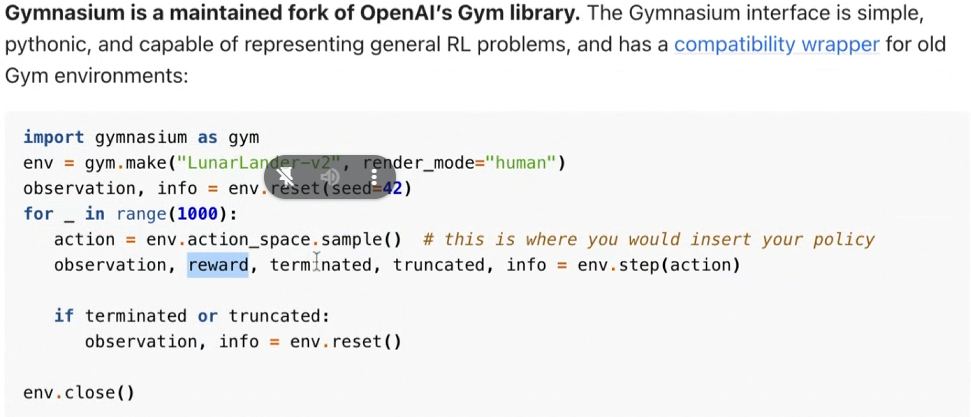

In [1]:
%pip install gymnasium
%pip install swig
%pip install gymnasium[box2d]


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pygame-2.5.2-cp311-cp311-win_amd64.whl.metadata (13 kB)
Using cached pygame-2.5.2-cp311-cp311-win_amd64.whl (10.8 MB)
  Running setup.py clean for box2d-py
Failed to build box2d-py
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 68.2.2).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\Box2D
      copying library\Box2D\Box2D.py -> build\lib.win-amd64-cpython-311\Box2D
      copying library\Box2D\__init__.py -> build\lib.win-amd64-cpython-311\Box2D
      creating build\lib.win-amd64-cpython-311\Box2D\b2
      copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-cpython-311\Box2D\b2
      running build_ext
      building 'Box2D._Box2D' extension
      swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
      swig.exe -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library\Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D\Box2D_wrap.cpp Box2D\Box2D.i
      error: comman

In [ ]:
import gymnasium as gym

# Créer un environnement pour "LunarLander-v2" avec le mode de rendu "human"
env = gym.make("LunarLander-v2", render_mode="human")

# Réinitialiser l'environnement avec une graine spécifique
observation, info = env.reset(seed=42)

# Exécuter une boucle 1000 fois
for _ in range(1000):
    # Choisir une action à partir de l'espace d'action
    action = env.action_space.sample()  # c'est ici que vous inséreriez votre politique

    # Exécuter l'action et obtenir l'observation, la récompense, et les indicateurs de fin et de troncature
    observation, reward, terminated, truncated, info = env.step(action)

    # Si l'épisode est terminé ou tronqué, réinitialiser l'environnement
    if terminated or truncated:
        observation, info = env.reset()

# Fermer l'environnement après l'exécution
env.close()



# Jeu du représentant de commerce
## création du terrain de jeu

In [31]:
%pip install swig
# !pip install gymnasium
# !pip install huggingface_hub
# # Optionnel: Installer stable-baselines3 pour des algorithmes RL
# !pip install stable-baselines3
# pour installer gymnasium et  box2d il est preferable de passer par le "shell conda install -c conda-forge pybox2d"

%pip install box2d-py



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached box2d-py-2.3.8.tar.gz (374 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for box2d-py
Failed to build box2d-py
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [16 lines of output]
      Using setuptools (version 68.2.2).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-cpython-311
      creating build\lib.win-amd64-cpython-311\Box2D
      copying library\Box2D\Box2D.py -> build\lib.win-amd64-cpython-311\Box2D
      copying library\Box2D\__init__.py -> build\lib.win-amd64-cpython-311\Box2D
      creating build\lib.win-amd64-cpython-311\Box2D\b2
      copying library\Box2D\b2\__init__.py -> build\lib.win-amd64-cpython-311\Box2D\b2
      running build_ext
      building 'Box2D._Box2D' extension
      swigging Box2D\Box2D.i to Box2D\Box2D_wrap.cpp
      swig.exe -python -c++ -IBox2D -small -O -includeall -ignoremissing -w201 -globals b2Globals -outdir library\Box2D -keyword -w511 -D_SWIG_KWARGS -o Box2D\Box2D_wrap.cpp Box2D\Box2D.i
      error: comman

In [20]:
import numpy as np
# Dimensions du terrain de jeu
largeur = 8
hauteur = 8

# Initialisation du terrain de jeu avec des zéros (0 = espace vide)
terrain = np.full((hauteur, largeur),'', dtype=str)

# Définition des points spéciaux
point_A = (0, 0)  # Point de départ
point_B = (7, 7)  # Point d'arrivée
lieux = [(1, 2), (0, 6),(7, 2),(2, 1), (5, 3), (6,5)]  # Emplacements des 3 lieux différents

# Placement des points spéciaux sur le terrain
terrain[point_A] = 'A'  # Point de départ
terrain[point_B] = 'B'  # Point d'arrivée
for i, lieu in enumerate(lieux):
    # terrain[lieu] = f"{i+1}"  # Lieux
    terrain[lieu] = "L" + str(i)  # Lieux

# Affichage du terrain de jeu
print(terrain)



[['A' '' '' '' '' '' 'L' '']
 ['' '' 'L' '' '' '' '' '']
 ['' 'L' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '']
 ['' '' '' '' '' '' '' '']
 ['' '' '' 'L' '' '' '' '']
 ['' '' '' '' '' 'L' '' '']
 ['' '' 'L' '' '' '' '' 'B']]


In [21]:
# Initialisation du terrain de jeu avec 'L99' (0 = espace vide)
terrain = np.full((hauteur, largeur),'L99', dtype=str)

# Placement des points spéciaux sur le terrain
terrain[point_A] = 'A'  # Point de départ
terrain[point_B] = 'B'  # Point d'arrivée
for i, lieu in enumerate(lieux):
    terrain[lieu] = f"L{i+1}"  # Lieux

# Remplacement des 'L99' restants par des espaces vides
terrain[terrain == 'L99'] = ''


In [22]:
# Affichage du terrain de jeu
print(terrain)


[['A' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'L']
 ['L' 'L' 'L' 'L' 'L' 'L' 'L' 'B']]


## Import modéle taxi de gymnasium

In [3]:
from huggingface_hub import hf_hub_download
import gymnasium as gym

# Assurez-vous d'avoir la dernière version de gymnasium qui inclut Taxi-v3
env = gym.make("Taxi-v3")

# Télécharger le modèle (exemple hypothétique, ajustez selon la documentation spécifique)
model_path = hf_hub_download(repo_id="VcRlAgent/VC-Taxi-v3-Gymnasium", filename="model.zip")

# Charger le modèle - L'implémentation dépendra du type de modèle et de la manière dont il est sauvegardé
# Vous devrez peut-être extraire le modèle et le charger avec une bibliothèque d'apprentissage par renforcement

obs = env.reset()
done = False
while not done:
    action = model.predict(obs)  # Hypothétique, dépend de l'API du modèle
    obs, reward, done, info = env.step(action)
    env.render()


EntryNotFoundError: 404 Client Error. (Request ID: Root=1-65cd0262-142cea7652ec19666f347a6f;c067224d-ba2c-4c71-9704-ac125317d160)

Entry Not Found for url: https://huggingface.co/VcRlAgent/VC-Taxi-v3-Gymnasium/resolve/main/model.zip.

In [2]:
import gymnasium as gym

# Créer un environnement pour "LunarLander-v2" avec le mode de rendu "human"
env = gym.make("LunarLander-v2", render_mode="human")

# Réinitialiser l'environnement avec une graine spécifique
observation, info = env.reset(seed=42)

# Exécuter une boucle 1000 fois
for _ in range(1000):
    # Choisir une action à partir de l'espace d'action
    # Remplacer cette ligne par votre politique ou modèle d'apprentissage par renforcement
    action = env.action_space.sample()  # Action aléatoire, à remplacer par votre politique

    # Exécuter l'action et obtenir l'observation, la récompense, et les indicateurs de fin et de troncature
    observation, reward, terminated, truncated, info = env.step(action)

    # Si l'épisode est terminé ou tronqué, réinitialiser l'environnement
    if terminated or truncated:
        observation, info = env.reset()

# Fermer l'environnement après l'exécution
env.close()


DependencyNotInstalled: pygame is not installed, run `pip install gymnasium[box2d]`